# DISCLAIMER: This Notebook can only be executed when models are loaded. However, the .keras model files could not be included into the submission as each file was too big (>500MB).


In [47]:
import os
import io
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from keras.models import load_model
import random

import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import classification_report


## Help Functions

In [48]:
image_size=224
channels=3
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically

def create_labels (labels):
    y_labels = []
    for label in labels: 
        y_labels.append(label)
    y_labels = np.array(y_labels)
    return y_labels


def true_and_predicted_classes(predictions, labels):
    predicted_classes = []
    true_classes = []
    for prediction in predictions:  
        pred = np.argmax(prediction)
        predicted_classes.append(pred)
    for label in labels: 
        true = np.argmax(label)
        true_classes.append(true)
    return predicted_classes, true_classes


def print_predictions(labels, preds, predictions):
    """Predictions based on test dataset."""
    #predict
    for label,pred, prediction in zip(labels, preds, predictions):
        
            print("Prediction:", prediction,"Pred. Class: ",pred, "Actual Label:", label)# Print the first prediction
        

def evaluate_model(model, X_test, y_test):
    result = model.evaluate(X_test, y_test)
    # Assuming accuracy was the second metric (index 1), extract the accuracy.
    test_accuracy = result[1] * 100  # Convert to percentage
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


def print_conf_matrix(true_classes, predicted_classes):
    """
    Print confusion matrix.
    """
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    df_cm = pd.DataFrame(
        conf_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=(8,5))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')

    # Set aesthetics for better readability
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


def plot_image(index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Plot the image 
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Label: {class_names[y_true]}")
    plt.title("Image with Predicted and Actual Labels")
    plt.show()

def plot_image_pred(model, index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Predict the label using the model
    y_pred = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Image with Predicted and Actual Labels")
    plt.show()


def plot_wrong_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] != predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Wrong predicted image")
    plt.show()
    
def plot_correct_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] == predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}")
    plt.title("Correct predicted image")
    plt.show()


## Load Data

In [49]:
#read csv files to get filepaths and labels 
df_train= pd.read_csv("data/FINAL_METER_ML_train_2000.csv")
df_val = pd.read_csv("data/FINAL_METER_ML_val.csv")
df_test = pd.read_csv("data/FINAL_METER_ML_test.csv")

# convert each string in the DataFrame to a list
df_train['Label'] = df_train['Label'].apply(ast.literal_eval).apply(np.array)
df_val['Label'] = df_val['Label'].apply(ast.literal_eval).apply(np.array)
df_test['Label'] = df_test['Label'].apply(ast.literal_eval).apply(np.array)


#define class names for later use
class_names=["CAFOs","Landfills","Mines","Negative","ProcessingPlants","RefineriesAndTerminals","WWTreatment"]

#convert the label labels to arrays in a list
y_train = np.array(df_train['Label']).tolist()
y_val = np.array(df_val['Label']).tolist()
y_test = np.array(df_test['Label']).tolist()


#import images from previous created .npy files from personal drive
X_val = np.load('/Volumes/SSD/x_val.npy')
X_test = np.load('/Volumes/SSD/x_test.npy')
X_train = np.load('/Volumes/SSD/x_train.npy')

#create labels
y_val = create_labels(y_val)
y_train = create_labels(y_train)
y_test = create_labels(y_test)


## RESNET

In [50]:
#import the model from local drive
resnet_model = tf.keras.models.load_model("/Volumes/SSD/RUNS/HATI/RUN2/resnet_model.keras")


In [51]:
#predict test set
predictions_rn = resnet_model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step


In [52]:
# print accuracy of test predictions
evaluate_model(resnet_model, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4878 - loss: 1.4934
Test Accuracy: 35.86%


35.85858643054962

In [53]:
#get true classes and predicted classes in lists
true_classes_rn, predicted_classes_rn = true_and_predicted_classes(predictions_rn, y_test)

In [54]:
#print evaluation metrices
print(f"Accuracy Score: {accuracy_score(true_classes_rn, predicted_classes_rn)}")
print(f"F1 Score: {f1_score(true_classes_rn, predicted_classes_rn, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_rn, predicted_classes_rn, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_rn, predicted_classes_rn, average='weighted')}")

Accuracy Score: 0.35858585858585856
F1 Score: 0.3728123972390291
Recall Score: 0.35858585858585856
Precision Score: 0.5086434170476751


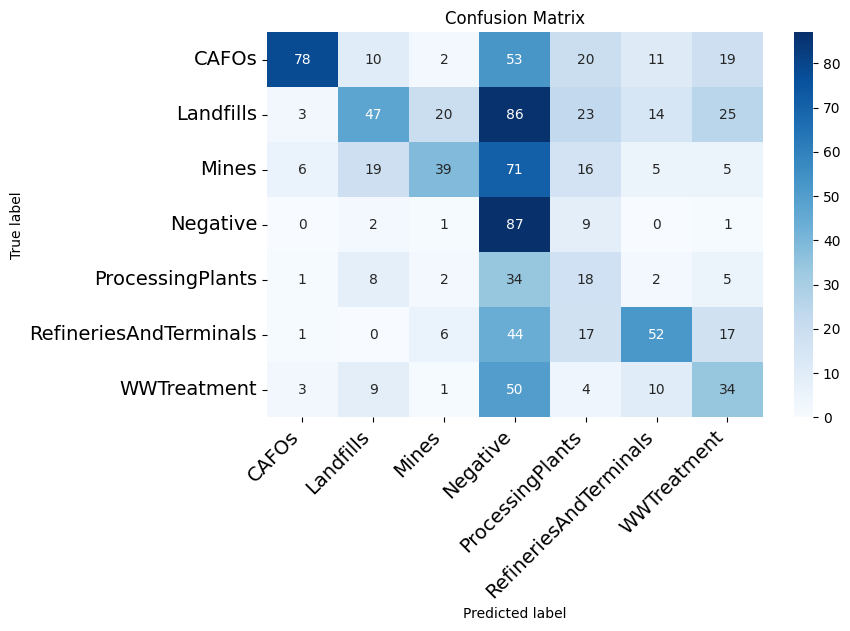

In [55]:
#print confusion matrix
print_conf_matrix(true_classes_rn, predicted_classes_rn)

In [56]:
#print the classifiaction report - evaluation metrices accross the different classes
report_rn = classification_report(true_classes_rn, predicted_classes_rn)
print(report_rn)


              precision    recall  f1-score   support

           0       0.85      0.40      0.55       193
           1       0.49      0.22      0.30       218
           2       0.55      0.24      0.34       161
           3       0.20      0.87      0.33       100
           4       0.17      0.26      0.20        70
           5       0.55      0.38      0.45       137
           6       0.32      0.31      0.31       111

    accuracy                           0.36       990
   macro avg       0.45      0.38      0.35       990
weighted avg       0.51      0.36      0.37       990



## RESNET FINE TUNING

In [57]:
#import the model from local drive
resnet_model_ft = tf.keras.models.load_model("/Volumes/SSD/RUNS/HATI/RUN2/resnet_model_tf.keras")


In [58]:
#predict test set
predictions_rn_ft = resnet_model_ft.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step


In [59]:
# print accuracy of test predictions
evaluate_model(resnet_model_ft, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4918 - loss: 1.6528
Test Accuracy: 44.44%


44.44444477558136

In [60]:
#get true classes and predicted classes in lists
true_classes_ft, predicted_classes_ft = true_and_predicted_classes(predictions_rn_ft, y_test)

In [61]:
#print evaluation metrices
print(f"Accuracy Score: {accuracy_score(true_classes_ft, predicted_classes_ft)}")
print(f"F1 Score: {f1_score(true_classes_ft, predicted_classes_ft, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_ft, predicted_classes_ft, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_ft, predicted_classes_ft, average='weighted')}")

Accuracy Score: 0.4444444444444444
F1 Score: 0.43885851494715156
Recall Score: 0.4444444444444444
Precision Score: 0.4925293456110719


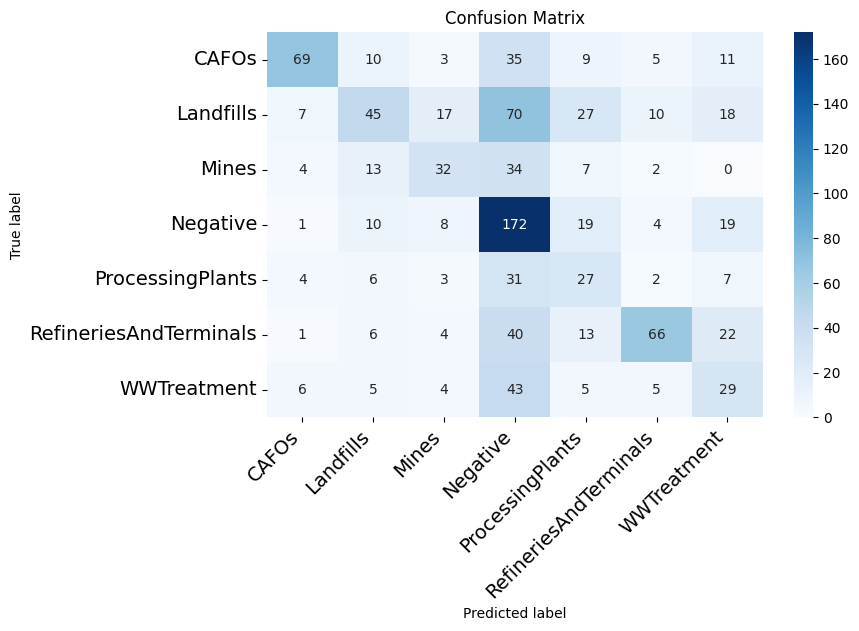

In [62]:
#print confusion matrix
print_conf_matrix(true_classes_ft, predicted_classes_ft)

In [63]:
#print the classifiaction report - evaluation metrices accross the different classes
report_ft = classification_report(true_classes_ft, predicted_classes_ft)
print(report_ft)

              precision    recall  f1-score   support

           0       0.75      0.49      0.59       142
           1       0.47      0.23      0.31       194
           2       0.45      0.35      0.39        92
           3       0.40      0.74      0.52       233
           4       0.25      0.34      0.29        80
           5       0.70      0.43      0.54       152
           6       0.27      0.30      0.29        97

    accuracy                           0.44       990
   macro avg       0.47      0.41      0.42       990
weighted avg       0.49      0.44      0.44       990



## ALEXNET

In [152]:
#import the model from local drive
alexnet = tf.keras.models.load_model("/Volumes/SSD/RUNS/HATI/RUN2/alexnet.keras")


In [153]:
#predict test set
predictions_an = alexnet.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 533ms/step


In [154]:
# print accuracy of test predictions
evaluate_model(alexnet, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 446ms/step - accuracy: 0.4650 - loss: 1.4781
Test Accuracy: 41.41%


41.41414165496826

In [155]:
#get true classes and predicted classes in lists
true_classes_an, predicted_classes_an = true_and_predicted_classes(predictions_an, y_test)

In [156]:
#print evaluation metrices
print(f"Accuracy Score: {accuracy_score(true_classes_an, predicted_classes_an)}")
print(f"F1 Score: {f1_score(true_classes_an, predicted_classes_an, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_an, predicted_classes_an, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_an, predicted_classes_an, average='weighted')}")

Accuracy Score: 0.41414141414141414
F1 Score: 0.4068248078169028
Recall Score: 0.41414141414141414
Precision Score: 0.46703872317031936


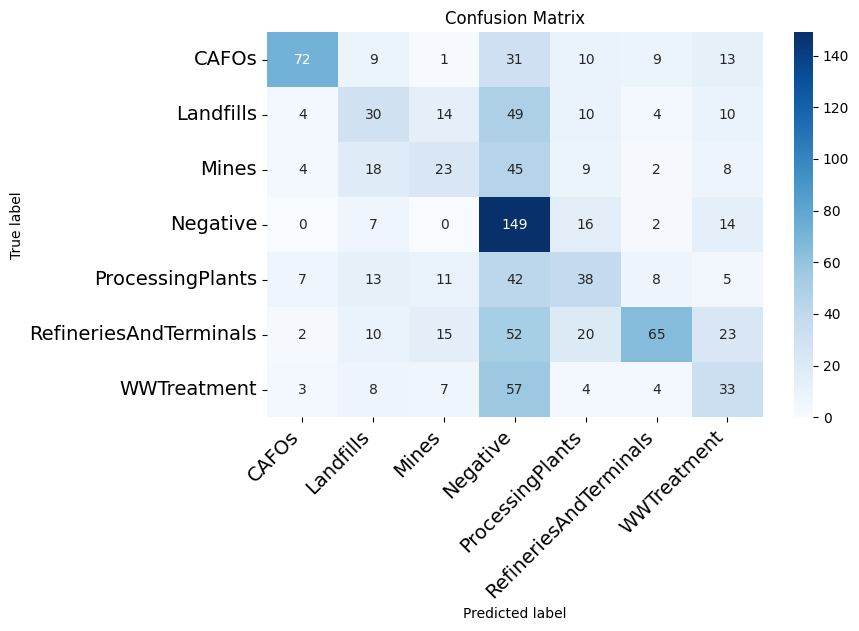

In [157]:
#print confusion matrix
print_conf_matrix(true_classes_an, predicted_classes_an)

In [158]:
#print the classifiaction report - evaluation metrices accross the different classes
report_an = classification_report(true_classes_an, predicted_classes_an)
print(report_an)

              precision    recall  f1-score   support

           0       0.78      0.50      0.61       145
           1       0.32      0.25      0.28       121
           2       0.32      0.21      0.26       109
           3       0.35      0.79      0.49       188
           4       0.36      0.31      0.33       124
           5       0.69      0.35      0.46       187
           6       0.31      0.28      0.30       116

    accuracy                           0.41       990
   macro avg       0.45      0.38      0.39       990
weighted avg       0.47      0.41      0.41       990



## VGG16

In [71]:
#import the model from local drive
vgg16 = tf.keras.models.load_model("/Volumes/SSD/RUNS/KORE/VGG16_model_2.keras")


In [72]:
#predict test set
predictions_vgg = vgg16.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 242s 8s/step


In [73]:
# print accuracy of test predictions
evaluate_model(vgg16, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.5608 - loss: 1.3135
Test Accuracy: 46.16%


46.16161584854126

In [74]:
#get true classes and predicted classes in lists
true_classes_vgg, predicted_classes_vgg = true_and_predicted_classes(predictions_vgg, y_test)

In [75]:
#print evaluation metrices
print(f"Accuracy Score: {accuracy_score(true_classes_vgg, predicted_classes_vgg)}")
print(f"F1 Score: {f1_score(true_classes_vgg, predicted_classes_vgg, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_vgg, predicted_classes_vgg, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_vgg, predicted_classes_vgg, average='weighted')}")

Accuracy Score: 0.4616161616161616
F1 Score: 0.4531259074348555
Recall Score: 0.4616161616161616
Precision Score: 0.5722660511083569


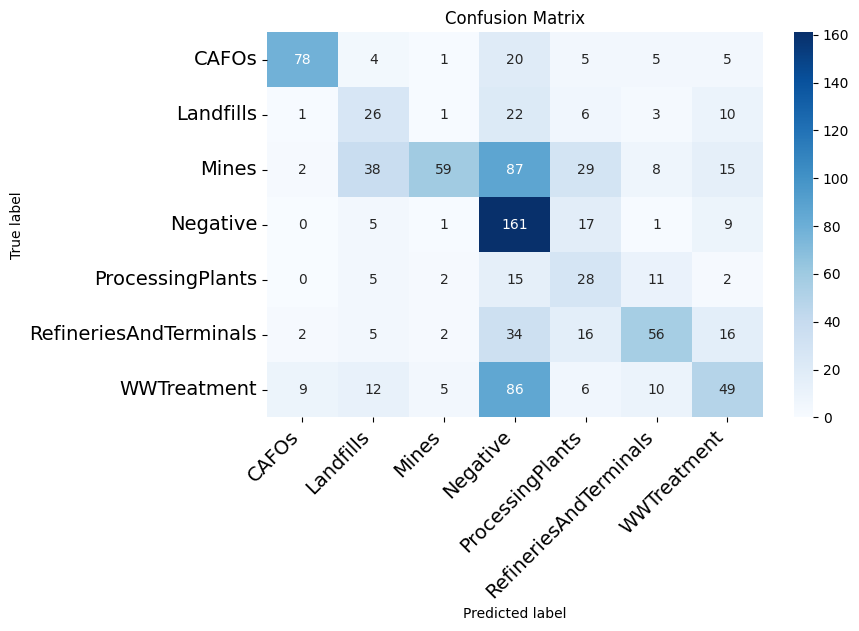

In [76]:
#print confusion matrix
print_conf_matrix(true_classes_vgg, predicted_classes_vgg)

In [77]:
#print the classifiaction report - evaluation metrices accross the different classes
report_vgg = classification_report(true_classes_vgg, predicted_classes_vgg)
print(report_vgg)

              precision    recall  f1-score   support

           0       0.85      0.66      0.74       118
           1       0.27      0.38      0.32        69
           2       0.83      0.25      0.38       238
           3       0.38      0.83      0.52       194
           4       0.26      0.44      0.33        63
           5       0.60      0.43      0.50       131
           6       0.46      0.28      0.35       177

    accuracy                           0.46       990
   macro avg       0.52      0.47      0.45       990
weighted avg       0.57      0.46      0.45       990



## Plot Images

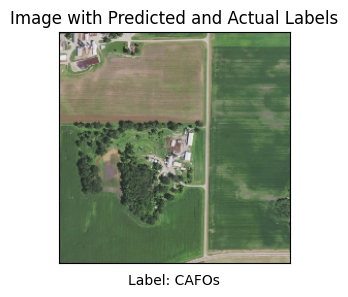

In [78]:
plot_image(60, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


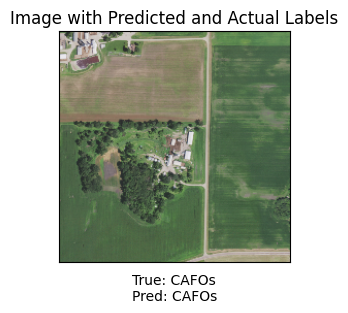

In [79]:
plot_image_pred(vgg16, 60, X_test, y_test)

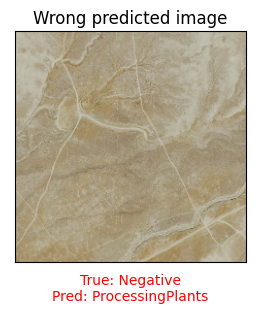

In [121]:
plot_wrong_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

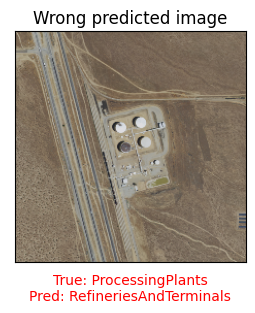

In [116]:
plot_wrong_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

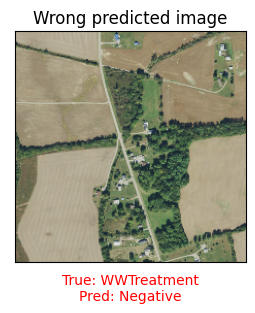

In [128]:
plot_wrong_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

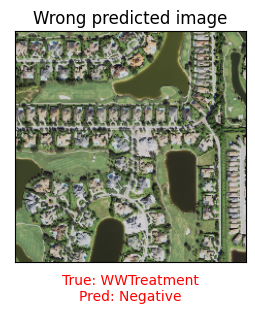

In [83]:
plot_wrong_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

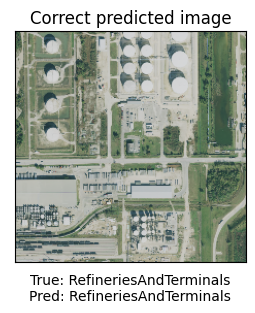

In [84]:
plot_correct_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

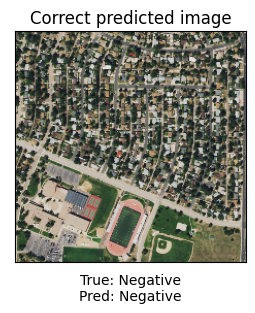

In [141]:
plot_correct_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

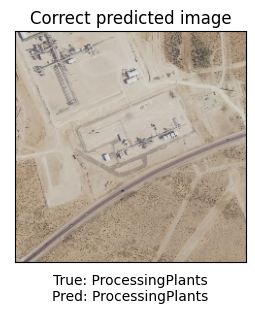

In [151]:
plot_correct_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)

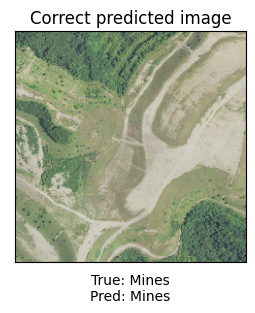

In [137]:
plot_correct_pred_image(X_test, true_classes_vgg, predicted_classes_vgg)